<img src="https://www.rp.edu.sg/images/default-source/default-album/rp-logo.png" width="200" alt="Republic Polytechnic"/>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ipomoeabatatas/ubts_day_02/blob/main/Agents/Activity_03.ipynb)

## Build Agents with access to RAG Tools Using Llamaindex

In this lesson, you’ll take a deeper dive into tool use within multi-agent systems, with a focus on advanced capabilities like LlamaIndex for Retrieval-Augmented Generation (RAG).

LlamaIndex is a powerful framework that connects LLMs to private and external data sources, enabling smarter, context-aware responses.

Building on earlier concepts, you’ll learn how to empower agents with access to your own documentation—enabling them to retrieve, interpret, and act on external, domain-specific knowledge. You’ll also see how this integrates seamlessly with the CrewAI framework, allowing your agents to collaborate intelligently using shared memory and contextual tools

### Getting Started.

This notebook is designed to work in Google Colab.
For secret and keys, it has to be stored and accessed via the Secrets feature.

**Create** a secret key OPENAI_API_KEY using the SECRET Features.

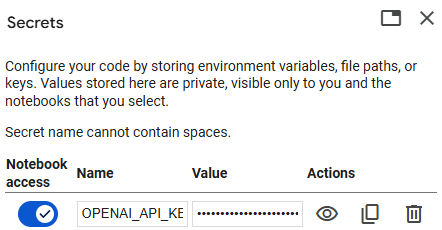

## Install the required projects


In [ ]:
!pip install crewai==0.108.0
!pip install crewai-tools==0.40.0
!pip install boto3  # workaround for incomplete crewai-tools dependency
!pip install llama-index[all]
!pip install wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 528.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.3 MB/s eta 0:0

In [ ]:
! pip freeze | grep crewai

crewai==0.108.0
crewai-tools==0.40.0


Expected results:  
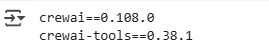

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime
import wget


# Set variables for control
__TODO__ = None
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')  # e.g., 20250408_153012


Import from the crewAI library.


In [ ]:


from google.colab import userdata
from crewai import Agent, Task, Crew, LLM


## Llamaindex Basic

LlamaIndex is a data framework that bridges large language models (LLMs) with external data sources—such as PDFs, databases, APIs, or custom documentation. It enables LLMs to perform Retrieval-Augmented Generation (RAG) by retrieving relevant context before generating responses. This is especially important when building intelligent systems that require up-to-date or domain-specific knowledge beyond the model’s training data. With LlamaIndex, agents can reason more accurately, provide grounded answers, and work effectively with real-world information.



In [ ]:
import os
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.llms.openai import OpenAI
from crewai_tools import LlamaIndexTool
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

## Settings

The Settings is a bundle of commonly used resources used during the indexing and querying stage in a LlamaIndex workflow/application.

The Settings is a simple singleton object that lives throughout your application. Whenever a particular component is not provided, the Settings object is used to provide it as a global default.
You can use it to set the global configuration.

If needed, local configurations (transformations, LLMs, embedding models) can be passed directly into the interfaces to over-ride the global configurations.


In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

llm_model = "gpt-4o"
embed_model = "text-embedding-ada-002"

Settings.llm = OpenAI(temperature=0.1, model=llm_model)
Settings.embed_model = OpenAIEmbedding(model=embed_model)


## Data Connectors

A data connector is a tool in LlamaIndex that helps you load and access data from different sources, such as PDFs, websites, databases, folders, or APIs.

Think of it as a bridge between your raw data and the AI system. It brings in the content you want your agent to use—whether it's documents, emails, or spreadsheets—so that it can be indexed and searched using LlamaIndex.

Example:
If you want your agent to use information from a folder of shipping reports, a data connector can read those files and prepare them for use in your RAG (Retrieval-Augmented Generation) pipeline.



### Simple Directory Reader
SimpleDirectoryReader is the simplest way to load data from local files into LlamaIndex. For production use cases it's more likely that you'll want to use one of the many Readers available on LlamaHub, but SimpleDirectoryReader is a great way to get started.

As a first step, we will prepare the folder with files to load.

In [ ]:
input_dir = "private_data"
# check if folder exist
if not os.path.exists(input_dir):
      print (f"The input directory '{input_dir}' does not exist. Let's create one")
      os.makedirs(input_dir, exist_ok=True)

url = "https://raw.githubusercontent.com/Ipomoeabatatas/ubts_day_02/main/Agents/Portnet.csv"
!wget {url} -P {input_dir}

url = "https://raw.githubusercontent.com/Ipomoeabatatas/ubts_day_02/main/Agents/E_Guide_for_Newly_Registered_Traders__Dec_2024_.pdf"
!wget {url} -P {input_dir}



--2025-04-15 13:06:41--  https://raw.githubusercontent.com/Ipomoeabatatas/ubts_day_02/main/Agents/Portnet.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 663 [text/plain]
Saving to: ‘private_data/Portnet.csv’

Portnet.csv         100%[===================>]     663  --.-KB/s    in 0s      

2025-04-15 13:06:41 (35.7 MB/s) - ‘private_data/Portnet.csv’ saved [663/663]

--2025-04-15 13:06:41--  https://raw.githubusercontent.com/Ipomoeabatatas/ubts_day_02/main/Agents/E_Guide_for_Newly_Registered_Traders__Dec_2024_.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, a

### Load in the files

We use SimpleDirectoryReader to read a folder (input_dir) and filters for specific file types (.pdf, .xlsx, .csv), including subfolders.

Then we load the content of those files and returns a list of Document objects. Each containing the text and metadata of a file or file section.


In [ ]:
reader = SimpleDirectoryReader(input_dir=input_dir, required_exts=[".pdf", ".xlsx", ".csv"], recursive=True)
documents = reader.load_data()


In [ ]:
documents[2]

Document(id_='45dd6c79-5a24-4c2d-928d-0bb226cbbdf4', embedding=None, metadata={'page_label': '3', 'file_name': 'E_Guide_for_Newly_Registered_Traders__Dec_2024_.pdf', 'file_path': '/content/private_data/E_Guide_for_Newly_Registered_Traders__Dec_2024_.pdf', 'file_type': 'application/pdf', 'file_size': 381295, 'creation_date': '2025-04-15', 'last_modified_date': '2025-04-15'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='1 \n \nPreface \n \nThis guide aims to provide newly registered traders with a brief introduction on Singapore \nCustoms’ procedures and requirements on import, export and/or transhipment activities. \n \nDisclaimer \n \nT

### Indexing
An Index is a data structure that allows us to quickly retrieve relevant context for a user query. For LlamaIndex, it's the core foundation for retrieval-augmented generation (RAG) use-cases.

At a high-level, Indexes are built from Documents. They are used to build Query Engines and Chat Engines which enables question & answer and chat over your data. Vector Stores are use to turn the documents into index.

By default, VectorStoreIndex stores everything in memory.There are alternatives
to have persistence storage.

In [ ]:
index = VectorStoreIndex.from_documents(documents)

/usr/local/lib/python3.11/dist-packages/llama_index/core/indices/base.py:110: DeprecationWarning: Call to deprecated method get_doc_id. ('get_doc_id' is deprecated, access the 'id_' property instead.) -- Deprecated since version 0.12.2.
  docstore.set_document_hash(doc.get_doc_id(), doc.hash)


In [ ]:
import random

# Access all nodes from the document store dictionary
all_nodes = list(index.docstore.docs.values())

# Pick one at random
random_node = random.choice(all_nodes)

# Display content and metadata
print("🔹 Text Preview:\n", random_node.text[:300], "...")
print("\n🔸 Metadata:\n", random_node.metadata)


🔹 Text Preview:
 AN HAI (ANHAI), 025S/025SS, COS, -, IHX, IHX, CSP, P34, 17/10/2024 9:00, 18/10/2024 9:00, Incoming
OCEAN STAR (OCSTAR), 01S/01SS, SIM, -, SVC, SIM, SIM, PPT1, 16/10/2024 1:00, 17/10/2024 1:30, Outgoing
PACIFIC DAWN (PACDAWN), 02S/02SS, SIM, -, SVC, SIM, SIM, PPT2, 16/10/2024 2:00, 17/10/2024 2:30, O ...

🔸 Metadata:
 {'file_path': '/content/private_data/Portnet.csv', 'file_name': 'Portnet.csv', 'file_type': 'text/csv', 'file_size': 663, 'creation_date': '2025-04-15', 'last_modified_date': '2025-04-15'}


### Create the Query Engine and Chat Engine

**Query engine** is a generic interface that allows you to ask question over your data.

A query engine takes in a natural language query, and returns a rich response. It is most often (but not always) built on one or many indexes via retrievers.

**Chat engine** is a high-level interface for having a conversation with your data (multiple back-and-forth instead of a single question & answer). Think ChatGPT, but augmented with your knowledge base.

Conceptually, it is a stateful analogy of a Query Engine. By keeping track of the conversation history, it can answer questions with past context in mind.

In [ ]:
query_engine = index.as_query_engine(similarity_top_k=5)
chat_engine = index.as_chat_engine(similarity_top_k=5)

## Questions and Answer
Here is how you carry out a simple questions and anwser on your data using the Chat Engine.

In [ ]:
queries = [
        "What are the  documentation needs to export things out of Singapore?",
        "What was arrival information for Vessel An Hai?",
        "Give the coordinates of Singapore",
        "How can I pay for import and export duties"
          ]

for q in queries:
  response = query_engine.query(q)
  print(f"{q}:\n ->{response} \n")

What are the  documentation needs to export things out of Singapore?:
 ->To export goods from Singapore, you need to declare the goods to Singapore Customs. It is important to prepare the necessary documents for cargo clearance and retain your trade documents. Additionally, you should apply for a customs export permit. 

What was arrival information for Vessel An Hai?:
 ->The vessel An Hai is scheduled to arrive on 17th October 2024 at 9:00 and depart on 18th October 2024 at 9:00. 

Give the coordinates of Singapore:
 ->I'm sorry, but I can't provide the coordinates of Singapore based on the given information. 

How can I pay for import and export duties:
 ->To pay for import and export duties, you need to have an Inter-bank GIRO (IBG) account set up. You can authorize your declaring agent to use this account for the payment of duties, GST, and other related fees. This involves completing the Application for the Authorisation of Declaring Agent(s) form with necessary details such as yo

### Create a LlamaIndexTool from the query engine

You will need to use the LlamaIndexTool to set up a query engine as a tool.
The wrapper is designed to be a general wrapper around LlamaIndex tools and query engines, enabling you to leverage LlamaIndex resources in terms of RAG/agentic pipelines as tools to plug into CrewAI agents. This tool allows you to seamlessly integrate LlamaIndex’s powerful data processing and retrieval capabilities into your CrewAI workflows.
https://docs.crewai.com/tools/llamaindextool

It is important to give a meaningful name and description to the tool.
The Agent will use the name and description to understand what the tool will do.


In [ ]:
query_on_private_data_tool = LlamaIndexTool.from_query_engine(
    query_engine,
    name="Company Data Query Tool",
    description="Use this tool to lookup information in company documents"
)

### Test the Query tool
We will test the query tool in a standalone mode, just to comfort ourselves that it is working well.

In [ ]:
queries = [
        "What are the  documentation needs to export things out of Singapore?",
        "What was arrival information for Vessel An Hai?",
        "Give the coordinates of Singapore",
        "How can I pay for import and export duties"
          ]

for query in queries:
    response = query_on_private_data_tool.run(query)
    print(f"{query} \n -> {response}\n")

Using Tool: Company Data Query Tool
What are the  documentation needs to export things out of Singapore? 
 -> To export goods from Singapore, you need to declare the goods to Singapore Customs. Additionally, you must prepare the necessary documents for cargo clearance and retain your trade documents. It is also important to check if your goods are controlled and apply for the appropriate customs export permit.

Using Tool: Company Data Query Tool
What was arrival information for Vessel An Hai? 
 -> The vessel An Hai was scheduled to arrive on 17th October 2024 at 9:00 and depart on 18th October 2024 at 9:00.

Using Tool: Company Data Query Tool
Give the coordinates of Singapore 
 -> I'm sorry, but I can't provide the coordinates of Singapore.

Using Tool: Company Data Query Tool
How can I pay for import and export duties 
 -> To pay for import and export duties, you need to have an Inter-bank GIRO (IBG) account set up. You can authorize a declaring agent to use your IBG account for the

## Define the LLM For The Agent
In the example below, OpenAI is used. We can either
set the connection information through the environment variables,
or directly input as a parameter in the LLM class.

In [ ]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
#os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'

## TODO : Instantiate the LLM model
llm = LLM(model="openai/gpt-4o",  # try replace with gpt-4o-mini
          api_key=userdata.get('OPENAI_API_KEY')
)


## Creating Agents

- Define your Agents, and provide them a `role`, `goal` and `backstory`.
- It has been seen that LLMs perform better when they are role playing.

This crew will have two agents. The first (qa_agent) will ingest the message and find answers. The second (reply_agent) will draft a short response
using the context provided by the first agent.


## Define the agent
## Include the parameter to assign the tools to the agent



In [ ]:
qa_agent = Agent(
    role="Answer Finder",
    goal="Only use external tools to find accurate answers to queries",
    backstory="You are well versed in attending to customer queries."
              "You're a highly knowledgeable agent with access to company private data."
              "You're an agent that NEVER guesses. "
              "You strictly search for answers information using the given tools."
               "===Question==="
              "{question}",
    llm=llm,
    allow_delegation=False,
    ## TODO: Assign the llamaindex query tool
    tools=[__TODO__],
	  verbose=False
)

### Agent: Writer

In [ ]:
reply_agent = Agent(
    role="Reply Composer",
    goal="Write thoughtful and helpful repliesreply to user messages using provided answers",
    backstory="You're a polite and articulate assistant who composes professional, human-like responses",
    llm= llm ,
    allow_delegation=False,
    verbose=False
)

## Creating Tasks

- Define your Tasks, and provide them a `description`, `expected_output` and `agent`.

### Task: Find Answer

In [ ]:
find_answers_task = Task(
    description="Find accurate and recent answers to the following question or questions:"
                 "You should only use the tool as a true source of answer and not rely on the model knowledge."
                  "If you cannot find the answer, provide the answer that you will get back soon with answer.",

    expected_output="Question/answers pairs based only on results of query on private data",
    agent=qa_agent,
    ## TO DO : Assign the tool
    tools=[__TODO__]
)

### Task: Write a Reply Note

This task will also output the results into a file reply-<timestamp>.md

In [ ]:
write_reply_task = Task(
    description="Write a friendly and informative reply to the user using the answers from the previous task.",
    expected_output="A 3-4 sentence reply written in a conversational tone.",
    agent=reply_agent,
    output_file=f'reply_{timestamp}.md'

)

## Creating the Crew

- Create your crew of Agents
- Pass the tasks to be performed by those agents.
    - **Note**: *For this simple example*, the tasks will be performed sequentially (i.e they are dependent on each other), so the _order_ of the task in the list _matters_.
- `verbose=True` allows you to see all the logs of the execution. Default is false

In [ ]:

crew = Crew(
    agents=[qa_agent, reply_agent ],
    tasks=[find_answers_task, write_reply_task],
    verbose=True
)

## Running the Crew

**Note**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

The reply will be saved to a file, as defined within the task.

In [ ]:
question =["What are the  documentation needs to export things out of Singapore?",
            "What is arrival information for Vessel An Hai?  ",
            "What are the coordinates of Singapore ",
            "Do I pay using customs using credit card"
            ]

result = crew.kickoff(inputs={"question": question})

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 8af3c9c5-27c8-4998-8871-b9d2a9317063                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress

# Agent: Answer Finder
## Task: Find accurate and recent answers to the following question or questions:You should only use the tool as a true source of answer and not rely on the model knowledge.If you cannot find the answer, provide the answer that you will get back soon with answer.


🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Using Company Data Query Tool (1)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (1)



# Agent: Answer Finder
## Using tool: Company Data Query Tool
## Tool Input: 
"{\"query\": \"documentation needs to export things out of Singapore\"}"
## Tool Output: 
To export goods from Singapore, you need to prepare the necessary documents for cargo clearance. This involves declaring the goods to Singapore Customs. It's important to check if your goods are controlled and apply for the appropriate customs export permit. Retaining your trade documents is also a crucial step in the process. For detailed information on the required documentation, you should refer to the relevant pages on the Customs website.


🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        ├── 🔧 Used Company Data Query Tool (1)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (1)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Using Company Data Query Tool (2)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (2)



# Agent: Answer Finder
## Using tool: Company Data Query Tool
## Tool Input: 
"{\"query\": \"arrival information for Vessel An Hai\"}"
## Tool Output: 
The vessel "An Hai" is scheduled to arrive on 17th October 2024 at 9:00 and is expected to depart on 18th October 2024 at 9:00.


🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        ├── 🔧 Used Company Data Query Tool (2)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (2)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Using Company Data Query Tool (3)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (3)



# Agent: Answer Finder
## Using tool: Company Data Query Tool
## Tool Input: 
"{\"query\": \"coordinates of Singapore\"}"
## Tool Output: 
I'm sorry, but I can't provide the coordinates of Singapore based on the given information.


You ONLY have access to the following tools, and should NEVER make up tools that are not listed here:

Tool Name: Company Data Query Tool
Tool Arguments: {'query': {'description': 'Search query for the query tool.', 'type': 'str'}}
Tool Description: Use this tool to lookup information in company documents

IMPORTANT: Use the following format in your response:

```
Thought: you should always think about what to do
Action: the action to take, only one name of [Company Data Query Tool], just the name, exactly as it's written.
Action Input: the input to the action, just a simple JSON object, enclosed in curly braces, using " to wrap keys and values.
Observation: the result of the action
```

Once all necessary information is gathered, return the following for

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        ├── 🔧 Used Company Data Query Tool (3)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (3)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Using Company Data Query Tool (4)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (4)



# Agent: Answer Finder
## Using tool: Company Data Query Tool
## Tool Input: 
"{\"query\": \"payment methods for customs Singapore\"}"
## Tool Output: 
For customs payments in Singapore, you can use an Inter-Bank GIRO (IBG) account. If you are a key or authorized personnel of an entity, you can authorize a declaring agent to use your IBG account for the payment of duties, GST, and other related fees. Additionally, security may be required for certain transactions, which can be lodged through a Banker's Guarantee or Insurance Bond.


🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        ├── 🔧 Used Company Data Query Tool (4)
        └── 🧠 Thinking...

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: In Progress
        └── 🔧 Used Company Data Query Tool (4)



# Agent: Answer Finder
## Final Answer: 
1. What are the documentation needs to export things out of Singapore?
   - To export goods from Singapore, you need to prepare the necessary documents for cargo clearance, declare the goods to Singapore Customs, check if your goods are controlled, apply for the appropriate customs export permit, and retain your trade documents. Detailed guidelines can be found on the Customs website.

2. What is the arrival information for Vessel An Hai?
   - The vessel "An Hai" is scheduled to arrive on 17th October 2024 at 9:00 and is expected to depart on 18th October 2024 at 9:00.

3. What are the coordinates of Singapore?
   - I was unable to retrieve the coordinates of Singapore through my available tools. I recommend checking a reliable map or geographical data source for this information.

4. Do I pay using customs using credit card?
   - For customs payments in Singapore, payments are typically made using an Inter-Bank GIRO (IBG) account. You can aut

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Status: Executing Task...
    └── 🤖 Agent: Answer Finder
            Status: ✅ Completed
        └── 🔧 Used Company Data Query Tool (4)

🚀 Crew: crew
└── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
       Assigned to: Answer Finder
       Status: ✅ Completed
    └── 🤖 Agent: Answer Finder
            Status: ✅ Completed
        └── 🔧 Used Company Data Query Tool (4)

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 9cca8d6e-cf58-4600-8d68-e5b008306e1a                                                                     │
│  Agent: Answer Finder                                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Status: Executing Task...
    └── 🤖 Agent: Reply Composer
            Status: In Progress

# Agent: Reply Composer
## Task: Write a friendly and informative reply to the user using the answers from the previous task.


🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Status: Executing Task...
    └── 🤖 Agent: Reply Composer
            Status: In Progress
        └── 🧠 Thinking...

🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Status: Executing Task...
    └── 🤖 Agent: Reply Composer
            Status: In Progress



# Agent: Reply Composer
## Final Answer: 
To successfully export goods from Singapore, ensure you prepare the necessary documentation, declare your goods to Customs, and apply for the appropriate export permit by checking if they are controlled. Meanwhile, the vessel "An Hai" will dock on 17th October 2024, with its departure slated for the following day. For payments related to customs, using an Inter-Bank GIRO account is standard, though you might need a Banker's Guarantee for specific transactions. If you require more details or assistance, feel free to ask!




🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Status: Executing Task...
    └── 🤖 Agent: Reply Composer
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 9cca8d6e-cf58-4600-8d68-e5b008306e1a
│      Assigned to: Answer Finder
│      Status: ✅ Completed
│   └── 🤖 Agent: Answer Finder
│           Status: ✅ Completed
│       └── 🔧 Used Company Data Query Tool (4)
└── 📋 Task: cd923d38-ceb7-4f57-aad1-31e29bc30bb4
       Assigned to: Reply Composer
       Status: ✅ Completed
    └── 🤖 Agent: Reply Composer
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: cd923d38-ceb7-4f57-aad1-31e29bc30bb4                                                                     │
│  Agent: Reply Composer                                                                                          │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 8af3c9c5-27c8-4998-8871-b9d2a9317063                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Display the results of your execution as markdown in the notebook.
- You may notice that the Agent have successful make queries against the private data source. However, it may have also tapped on its own knowledge.
As a challenge, iterate on the task and agent instructions.

In [ ]:
from IPython.display import Markdown
Markdown(result.raw)

To successfully export goods from Singapore, ensure you prepare the necessary documentation, declare your goods to Customs, and apply for the appropriate export permit by checking if they are controlled. Meanwhile, the vessel "An Hai" will dock on 17th October 2024, with its departure slated for the following day. For payments related to customs, using an Inter-Bank GIRO account is standard, though you might need a Banker's Guarantee for specific transactions. If you require more details or assistance, feel free to ask!

## Additional Activities

1. Find additional documents
2. Copy into the private_data folder
3. Update the Simple Directory to accept the new file types
4. Modify question set.